In [1]:
# bibliotecas
import json
import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt 
from IPython.display import clear_output

# regressores
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
# removendo máximo numero de colunas e linhas em display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# carrega todos os dados 
X_train = pd.read_csv("../outputs/X_train.csv").values
X_test = pd.read_csv("../outputs/X_test.csv").values
y_train = pd.read_csv("../outputs/y_train.csv").values.ravel()
y_test = pd.read_csv("../outputs/y_test.csv").values.ravel()

In [4]:
# Carrega os melhores parametros para cada modelo
best_params = json.load(open('../outputs/params_best.json'))

In [5]:
# salva as funções de cada modelo
functions_dict = {
    "Regressão Linear": LinearRegression,
    "Regressão LASSO": Lasso,
    "Regressão Ridge": Ridge,
    "Rede Elástica": ElasticNet,
    "K-Vizinhos Mais Próximos": KNeighborsRegressor,
    "Árvore de Decisão": DecisionTreeRegressor,
    "Árvores Extras": ExtraTreesRegressor,
    "Floresta Aleatória": RandomForestRegressor,
    "Gradiente Boosting Machine": GradientBoostingRegressor,
    "eXtreme Gradient Boosting": XGBRegressor,
    "Light Gradient Boosting": LGBMRegressor,
    "Categorical Boosting": CatBoostRegressor
}

In [6]:
# Palheta de cor para os gráficos
color_palette = {
    "Regressão Linear": "#1f77b4",
    "Regressão LASSO": "#aec7e8",
    "Regressão Ridge": "#ff7f0e",
    "Rede Elástica": "#9467bd",

    "K-Vizinhos Mais Próximos": "#2ca02c",

    "Árvore de Decisão": "#d62728",
    "Árvores Extras": "#7f7f7f",
    "Floresta Aleatória": "#e59d93",

    "Gradiente Boosting Machine": "#8c564b",
    "eXtreme Gradient Boosting": "#e377c2",
    "Light Gradient Boosting": "#17becf",
    "Categorical Boosting": "#bcbd22"
}


In [7]:
# Calculo de todas as notas, com e sem a transformação logaritimica
def make_scores(target, prediction):
 
    mse = np.mean((target-prediction)**2)
    rmse = np.sqrt(mse)
    mss = np.mean((target-np.mean(target))**2)
    r2 = 1 - mse/mss

    log_target = np.log(target)
    log_pred = np.log(prediction)
    
    mse_log = np.mean((log_target-log_pred)**2)
    rmse_log = np.sqrt(mse_log)
    mss_log = np.mean((log_target-np.mean(log_target))**2)
    r2_log = 1 - mse_log/mss_log

    return rmse, r2, rmse_log, r2_log

In [8]:
# Avalia cada modelo 
def multi_fit(X_train_full, y_train, X_test_full, y_test, functions_dict, parameters):

    # encontrando numero de atributos no dataset
    [n, max_p] = X_train_full.shape

    # Para cada tipo de score, se faz um dataframe vazio
    df_rmse = pd.DataFrame()
    df_r2 = pd.DataFrame()
    df_rmse_log = pd.DataFrame()
    df_r2_log = pd.DataFrame()

    # varia o numero de atributos
    for p in range(1, max_p+1):
        print(f'{p}/{max_p}')

        X_train = X_train_full[:,:p]
        X_test = X_test_full[:,:p]
        
        # para cada par de modelo e parametros se faz uma predição
        for name, func in functions_dict.items():
            params = parameters.get(name).get('params')
            model = func(**params)
            model.fit(X_train, y_train)
            pred = abs(model.predict(X_test))
            [rmse, r2, rmse_log, r2_log] = make_scores(y_test, pred)
            df_rmse.loc[p, name] = rmse
            df_r2.loc[p, name] = r2
            df_rmse_log.loc[p, name] = rmse_log
            df_r2_log.loc[p, name] = r2_log
        
    return df_rmse, df_rmse_log, df_r2, df_r2_log

In [9]:
# faz uma analise dos resultados e busc o melhor numero de atributos para cada resultado
def analyze_results(df_rmse, df_rmse_log, df_r2, df_r2_log, filename = None):
    
    analysis = {}
    best_algorithm = ""
    best_rmse_log = float('inf')
    
    for col in df_rmse_log.columns:

        p = float(df_rmse_log[col].idxmin())
        rmse_score = df_rmse.loc[p,col]
        rmse_log_score = df_rmse_log.loc[p,col]
        r2_score = df_r2.loc[p,col]
        r2_log_score = df_r2_log.loc[p,col]

        analysis[col] = {
            "p": p,
            "rmse score": rmse_score,
            "rmse-log score": rmse_log_score,
            "R2 score": r2_score,
            "R2-log score": r2_log_score
        }

        if best_rmse_log>rmse_log_score:
            best_algorithm = col
            best_rmse_log = rmse_log_score
            best_p = p
            best_r2 = r2_score


    print(f" O melhor algoritimo foi {best_algorithm} em p={best_p}")
    print(f" com score RMSE-log de {best_rmse_log}")
    print(f" e com score R2 de {best_r2}")

    if filename!=None:
        with open(filename, 'w') as f:
            json.dump(analysis, f, indent=4)
        print(f'\nResultados salvos em {filename}')
    
    return analysis

In [10]:
# treina, testa e avalia cada modelo, com os melhores parametros encontrados, para cada numero de atributos
df_rmse, df_rmse_log, df_r2, df_r2_log = multi_fit(X_train, y_train, X_test, y_test, functions_dict, best_params)

1/75
2/75
3/75
4/75
5/75
6/75
7/75
8/75
9/75
10/75
11/75
12/75
13/75
14/75
15/75
16/75
17/75
18/75
19/75
20/75
21/75
22/75
23/75
24/75
25/75
26/75
27/75
28/75
29/75
30/75
31/75
32/75
33/75
34/75
35/75
36/75
37/75
38/75
39/75
40/75
41/75
42/75
43/75
44/75
45/75
46/75
47/75
48/75
49/75
50/75
51/75
52/75
53/75
54/75
55/75
56/75
57/75
58/75
59/75
60/75
61/75
62/75
63/75
64/75
65/75
66/75
67/75
68/75
69/75
70/75
71/75
72/75
73/75
74/75
75/75


In [11]:
# faz analise dos resultados de cada modelo, buscando a iteração que o modelo teve melhor nota de cada metodo de avaliação
analysis = analyze_results(df_rmse, df_rmse_log, df_r2, df_r2_log, filename = '../outputs/results_analysis.json')
analysis

 O melhor algoritimo foi Categorical Boosting em p=71.0
 com score RMSE-log de 0.09606642190237233
 e com score R2 de 0.9332748694016595

Resultados salvos em ../outputs/results_analysis.json


{'Regressão Linear': {'p': 68.0,
  'rmse score': 24072.847455536248,
  'rmse-log score': 0.1254301133803617,
  'R2 score': 0.8975820583582809,
  'R2-log score': 0.8920783340667766},
 'Regressão LASSO': {'p': 69.0,
  'rmse score': 24008.30984842743,
  'rmse-log score': 0.12468472733537675,
  'R2 score': 0.8981304728052983,
  'R2-log score': 0.8933572020956386},
 'Regressão Ridge': {'p': 68.0,
  'rmse score': 23974.136881582963,
  'rmse-log score': 0.12394496543615849,
  'R2 score': 0.8984202646708702,
  'R2-log score': 0.8946188842605676},
 'Rede Elástica': {'p': 68.0,
  'rmse score': 23953.239527178164,
  'rmse-log score': 0.12342555486028381,
  'R2 score': 0.8985972739688715,
  'R2-log score': 0.8955002653774027},
 'K-Vizinhos Mais Próximos': {'p': 61.0,
  'rmse score': 26727.17097453781,
  'rmse-log score': 0.13418632036910863,
  'R2 score': 0.873751246348693,
  'R2-log score': 0.8764844891690741},
 'Árvore de Decisão': {'p': 49.0,
  'rmse score': 28823.94041857787,
  'rmse-log score

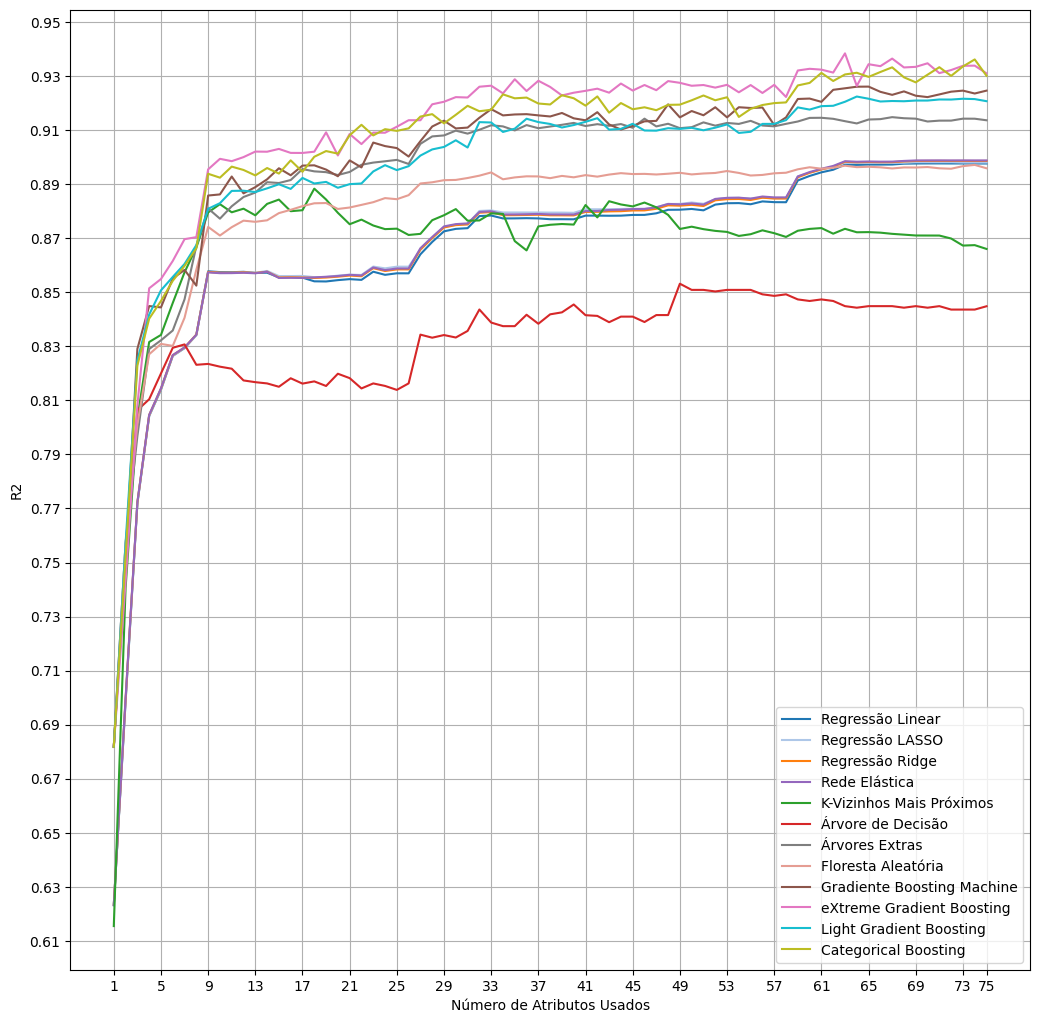

In [12]:
fig, ax = plt.subplots(figsize=(12, 12))
df_r2.plot(ax=ax, color=list(color_palette.values()))
ax.set_xlabel("Número de Atributos Usados")
ax.set_ylabel("R2")
ax.set_xticks([4*x+1 for x in range(19)]+[75])
ax.set_yticks([0.02*x+0.61 for x in range(18)])
ax.grid(True)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig('../outputs/R2.svg')
plt.show()